In [1]:
pip install neat-python

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import neat
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [3]:
# Загрузка и подготовка данных
def load_data():
    """Загрузка и предобработка данных"""
    data = load_wine()
    X = data.data  # (178, 13)
    y = data.target  # (178,)

    # Нормализация данных
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # Преобразование меток в one-hot encoding
    y_onehot = np.zeros((y.size, y.max()+1))
    y_onehot[np.arange(y.size), y] = 1

    # Разделение на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_onehot, test_size=0.2, random_state=42
    )

    return X_train, X_test, y_train, y_test

In [4]:
# Функция оценки приспособленности (fitness function)
def eval_genomes(genomes, config):
    """
    Оценка качества каждого генома в популяции
    Args:
        genomes: список кортежей (id генома, объект генома)
        config: конфигурация NEAT
    """
    X_train, X_test, y_train, y_test = load_data()

    for genome_id, genome in genomes:
        # Создание нейросети из генома
        net = neat.nn.FeedForwardNetwork.create(genome, config)

        # Прямое распространение (получение предсказаний)
        outputs = []
        for xi in X_train:
            output = net.activate(xi)
            outputs.append(output)

        # Вычисление точности
        y_pred = np.argmax(outputs, axis=1)
        y_true = np.argmax(y_train, axis=1)
        accuracy = accuracy_score(y_true, y_pred)

        # Приспособленность = точность классификации
        genome.fitness = accuracy - 0.001 * genome.size()[0]*genome.size()[1]

In [5]:
def visualize_network(genome, config):
    """Визуализация архитектуры нейросети"""
    from graphviz import Source
    node_names = {
        -1: 'Input 1', -2: 'Input 2', -3: 'Input 3', -4: 'Input 4',
        -5: 'Input 5', -6: 'Input 6', -7: 'Input 7', -8: 'Input 8',
        -9: 'Input 9', -10: 'Input 10', -11: 'Input 11', -12: 'Input 12',
        -13: 'Input 13', 0: 'Output 1', 1: 'Output 2', 2: 'Output 3'
    }
    dot = draw_net(config, genome, True, node_names=node_names)
    display(Source(dot.source))

In [6]:
# Основная функция запуска NEAT
def run_neat(config_file):
    """Запуск эволюционного процесса"""
    # Загрузка конфигурации NEAT
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Создание популяции
    p = neat.Population(config)

    # Добавление репортеров для отслеживания прогресса
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(5))

    # Запуск эволюции (максимум 50 поколений)
    winner = p.run(eval_genomes, 50)

    # Показать результаты
    print('\nЛучший геном:')
    print(winner)

    # Визуализация лучшей сети
    visualize_network(winner, config)

    return winner

In [7]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'


 ****** Running generation 0 ****** 

Population's average fitness: 0.20497 stdev: 0.16423
Best fitness: 0.75624 - size: (3, 39) - species 1 - id 3
Average adjusted fitness: 0.280
Mean genetic distance 1.211, standard deviation 0.237
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   200      0.8    0.280     0
Total extinctions: 0
Generation time: 0.622 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.39003 stdev: 0.16103
Best fitness: 0.75624 - size: (3, 39) - species 1 - id 3
Average adjusted fitness: 0.426
Mean genetic distance 1.339, standard deviation 0.247
Population of 200 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   200      0.8    0.426     1
Total extinctions: 0
Generation time: 0.790 sec (0.706 average)

 ****** Running generation 2 ****** 

Population's average fitness: 0.51767 stdev: 0.

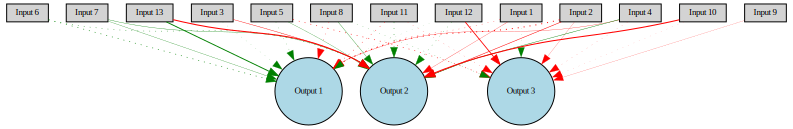


Точность на тестовых данных: 100.00%


In [ ]:
# Конфигурационный файл NEAT
config_path = '/content/drive/MyDrive/Работа/config-feedforward.txt'

# Запуск эволюции
best_genome = run_neat(config_path)

# Тестирование лучшей сети
X_train, X_test, y_train, y_test = load_data()
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_path)
best_net = neat.nn.FeedForwardNetwork.create(best_genome, config)

# Прогнозирование на тестовых данных
test_outputs = [best_net.activate(x) for x in X_test]
test_pred = np.argmax(test_outputs, axis=1)
test_true = np.argmax(y_test, axis=1)

# Вычисление финальной точности
final_accuracy = accuracy_score(test_true, test_pred)
print(f'\nТочность на тестовых данных: {final_accuracy:.2%}')

Ниже написан код для визуализации:

In [ ]:
import warnings

import graphviz
import matplotlib.pyplot as plt
import numpy as np


def plot_stats(statistics, ylog=False, view=False, filename='avg_fitness.svg'):
    """ Plots the population's average and best fitness. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    generation = range(len(statistics.most_fit_genomes))
    best_fitness = [c.fitness for c in statistics.most_fit_genomes]
    avg_fitness = np.array(statistics.get_fitness_mean())
    stdev_fitness = np.array(statistics.get_fitness_stdev())

    plt.plot(generation, avg_fitness, 'b-', label="average")
    plt.plot(generation, avg_fitness - stdev_fitness, 'g-.', label="-1 sd")
    plt.plot(generation, avg_fitness + stdev_fitness, 'g-.', label="+1 sd")
    plt.plot(generation, best_fitness, 'r-', label="best")

    plt.title("Population's average and best fitness")
    plt.xlabel("Generations")
    plt.ylabel("Fitness")
    plt.grid()
    plt.legend(loc="best")
    if ylog:
        plt.gca().set_yscale('symlog')

    plt.savefig(filename)
    if view:
        plt.show()

    plt.close()


def plot_spikes(spikes, view=False, filename=None, title=None):
    """ Plots the trains for a single spiking neuron. """
    t_values = [t for t, I, v, u, f in spikes]
    v_values = [v for t, I, v, u, f in spikes]
    u_values = [u for t, I, v, u, f in spikes]
    I_values = [I for t, I, v, u, f in spikes]
    f_values = [f for t, I, v, u, f in spikes]

    fig = plt.figure()
    plt.subplot(4, 1, 1)
    plt.ylabel("Potential (mv)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, v_values, "g-")

    if title is None:
        plt.title("Izhikevich's spiking neuron model")
    else:
        plt.title("Izhikevich's spiking neuron model ({0!s})".format(title))

    plt.subplot(4, 1, 2)
    plt.ylabel("Fired")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, f_values, "r-")

    plt.subplot(4, 1, 3)
    plt.ylabel("Recovery (u)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, u_values, "r-")

    plt.subplot(4, 1, 4)
    plt.ylabel("Current (I)")
    plt.xlabel("Time (in ms)")
    plt.grid()
    plt.plot(t_values, I_values, "r-o")

    if filename is not None:
        plt.savefig(filename)

    if view:
        plt.show()
        plt.close()
        fig = None

    return fig


def plot_species(statistics, view=False, filename='speciation.svg'):
    """ Visualizes speciation throughout evolution. """
    if plt is None:
        warnings.warn("This display is not available due to a missing optional dependency (matplotlib)")
        return

    species_sizes = statistics.get_species_sizes()
    num_generations = len(species_sizes)
    curves = np.array(species_sizes).T

    fig, ax = plt.subplots()
    ax.stackplot(range(num_generations), *curves)

    plt.title("Speciation")
    plt.ylabel("Size per Species")
    plt.xlabel("Generations")

    plt.savefig(filename)

    if view:
        plt.show()

    plt.close()


def draw_net(config, genome, view=False, filename=None, node_names=None, show_disabled=True, prune_unused=False,
             node_colors=None, fmt='svg'):
    """ Receives a genome and draws a neural network with arbitrary topology. """
    # Attributes for network nodes.
    if graphviz is None:
        warnings.warn("This display is not available due to a missing optional dependency (graphviz)")
        return

    # If requested, use a copy of the genome which omits all components that won't affect the output.
    if prune_unused:
        genome = genome.get_pruned_copy(config.genome_config)

    if node_names is None:
        node_names = {}

    assert type(node_names) is dict

    if node_colors is None:
        node_colors = {}

    assert type(node_colors) is dict

    node_attrs = {
        'shape': 'circle',
        'fontsize': '9',
        'height': '0.2',
        'width': '0.2'}

    dot = graphviz.Digraph(format=fmt, node_attr=node_attrs)

    inputs = set()
    for k in config.genome_config.input_keys:
        inputs.add(k)
        name = node_names.get(k, str(k))
        input_attrs = {'style': 'filled', 'shape': 'box', 'fillcolor': node_colors.get(k, 'lightgray')}
        dot.node(name, _attributes=input_attrs)

    outputs = set()
    for k in config.genome_config.output_keys:
        outputs.add(k)
        name = node_names.get(k, str(k))
        node_attrs = {'style': 'filled', 'fillcolor': node_colors.get(k, 'lightblue')}

        dot.node(name, _attributes=node_attrs)

    used_nodes = set(genome.nodes.keys())
    for n in used_nodes:
        if n in inputs or n in outputs:
            continue

        attrs = {'style': 'filled',
                 'fillcolor': node_colors.get(n, 'white')}
        dot.node(str(n), _attributes=attrs)

    for cg in genome.connections.values():
        if cg.enabled or show_disabled:
            # if cg.input not in used_nodes or cg.output not in used_nodes:
            #    continue
            input, output = cg.key
            a = node_names.get(input, str(input))
            b = node_names.get(output, str(output))
            style = 'solid' if cg.enabled else 'dotted'
            color = 'green' if cg.weight > 0 else 'red'
            width = str(0.1 + abs(cg.weight / 5.0))
            dot.edge(a, b, _attributes={'style': style, 'color': color, 'penwidth': width})

    dot.render(filename, view=view)

    return dot

Текст config файла:

In [ ]:
'''
[NEAT]
fitness_criterion     = max
fitness_threshold     = 1.0
pop_size              = 200
reset_on_extinction   = False

[DefaultGenome]
# Параметры узлов
num_inputs              = 13
num_hidden              = 0
num_outputs             = 3
feed_forward            = True
initial_connection      = full
compatibility_disjoint_coefficient = 1.0
compatibility_weight_coefficient = 0.5

# Параметры инициализации смещений
# Среднее значение для инициализации смещения
bias_init_mean          = 0.0
# Стандартное отклонение при инициализации
bias_init_stdev         = 1.0
# Максимальное значение смещения
bias_max_value          = 30.0
# Минимальное значение смещения
bias_min_value          = -30.0
# Сила изменения при мутации
bias_mutate_power       = 0.5
# Вероятность мутации смещения
bias_mutate_rate        = 0.7
# Вероятность полной замены значения
bias_replace_rate       = 0.1

# Параметры инициализации характеристик узлов (response)
# Среднее значение при инициализации
response_init_mean      = 1.0
# Стандартное отклонение
response_init_stdev     = 0.0
# Максимальное значение
response_max_value      = 30.0
# Минимальное значение
response_min_value      = -30.0
# Сила мутации
response_mutate_power   = 0.5
# Вероятность мутации
response_mutate_rate    = 0.1
# Вероятность замены значения
response_replace_rate   = 0.2

# Параметры активационных функций
activation_default      = sigmoid
# Вероятность изменения функции активации
activation_mutate_rate  = 0.05
# Доступные функции активации
activation_options      = sigmoid tanh relu

# Параметры мутаций
node_add_prob           = 0.1
node_delete_prob        = 0.2

# Параметры агрегационных функций
# Стандартная функция агрегации
aggregation_default         = sum
# Вероятность мутации агрегационной функции
aggregation_mutate_rate     = 0.1
# Доступные варианты агрегации
aggregation_options         = sum
# Среднее значение инициализации
aggregation_init_mean       = 0.0
# Стандартное отклонение
aggregation_init_stdev      = 1.0
# Максимальное значение
aggregation_max_value       = 30.0
# Минимальное значение
aggregation_min_value       = -30.0

# Параметры весовых коэффициентов
# Среднее значение при инициализации весов
weight_init_mean         = 0.0
# Стандартное отклонение при инициализации
weight_init_stdev        = 1.0
# Максимальное значение веса
weight_max_value         = 30.0
# Минимальное значение веса
weight_min_value         = -30.0
# Сила изменения веса при мутации
weight_mutate_power      = 0.5
# Вероятность мутации веса
weight_mutate_rate       = 0.8
# Вероятность полной замены значения веса
weight_replace_rate      = 0.1

# Параметры активации соединений
# Активировать новые соединения по умолчанию
enabled_default         = True
# Вероятность изменения состояния соединения
enabled_mutate_rate     = 0.1
# Вероятность добавления нового соединения
conn_add_prob           = 0.3
# Вероятность удаления существующего соединения
conn_delete_prob        = 0.5

[DefaultSpeciesSet]
compatibility_threshold = 2.0


[DefaultStagnation]
species_fitness_func = max
max_stagnation       = 50

[DefaultReproduction]
elitism            = 3
survival_threshold = 0.2
'''